This notebook shows how to solve the problem as a multi-class classification by finding candidate points based on geographic location.<br>
Similarity as a string, such as edit distance and LCS (Longest Common Subsequence), was used for the features of the candidate points.<br>
<br>
Inference is made on test data only, but the code for training is left commented out.<br>
<br>
In addition, making the matches bidirectional as a post-processing step improved the score by about 1%.<br>
<br>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import gc
import random
from glob import glob
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
import warnings
import seaborn as sns
import pickle
import json
import re
import time
import sys
from requests import get
import multiprocessing
import joblib
from collections import Counter, defaultdict
if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1

class CFG:
    seed = 46
    target = "point_of_interest"
    n_neighbors = 10
    n_splits = 3
    debug = False
    save = False

    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]

random.seed(CFG.seed)
os.environ["PYTHONHASHSEED"] = str(CFG.seed)
np.random.seed(CFG.seed)

plt.rcParams["font.size"] = 13
warnings.filterwarnings('ignore')

%cd /content/drive/MyDrive/Kaggle/Foursquare/Notebook

Found existing installation: lightgbm 2.2.3
Uninstalling lightgbm-2.2.3:
  Successfully uninstalled lightgbm-2.2.3
     |████████████████████████████████| 2.0 MB 33.5 MB/s 
/content/drive/MyDrive/Kaggle/Foursquare/Notebook


In [ ]:
OUTPUT_DIR = '../Output'
if not os.path.exists(os.path.join(OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(OUTPUT_DIR, CFG.expID))

In [ ]:
train = pd.read_csv("../Input/train.csv")
test = pd.read_csv("../Input/test.csv")
test[CFG.target] = "TEST"

train.head(1)

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e


In [ ]:
if CFG.debug:
    train = train[:10000]

# Devide Train Data into about 600K×2

In [ ]:
kf = GroupKFold(n_splits=2)
for i, (trn_idx, val_idx) in enumerate(kf.split(train, train[CFG.target], train[CFG.target])):
    train.loc[val_idx, "set"] = i
train["set"].value_counts()

1.0    569406
0.0    569406
Name: set, dtype: int64

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

def add_neighbor_features(df):
    dfs = []
    columns = ['id', 'name', 'address', 'city', 'state',
           'zip', 'country', 'url', 'phone', 'categories']
    for c in columns:
        if c != "id":
            df[c] = df[c].astype(str).str.lower()

    for country, country_df in tqdm(df.groupby("country")):
        country_dfs = []
        country_df = country_df.reset_index(drop=True)
        
        knn = KNeighborsRegressor(n_neighbors=min(len(country_df), CFG.n_neighbors), 
                                  metric='haversine', n_jobs=-1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude','longitude']], return_distance=True)
        targets = country_df[CFG.target].values
        for i in range(min(len(country_df), CFG.n_neighbors)):
            country_df_ = country_df.copy()
            country_df_[f"d_near"] = dists[:, i]
            country_df_[f"near_target"] = targets[nears[:, i]]
            for c in columns:
                country_df_[f"near_{c}"] = country_df_[c].values[nears[:, i]]
            country_dfs.append(country_df_)
        country_df = pd.concat(country_dfs)
        dfs.append(country_df)
    df = pd.concat(dfs).reset_index(drop=True)
    return df

train = pd.concat([
    add_neighbor_features(train[train["set"]==0]), 
    add_neighbor_features(train[train["set"]==1]), 
])
test = add_neighbor_features(test)

train.head(1)

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_id,near_name,near_address,near_city,near_state,near_zip,near_country,near_url,near_phone,near_categories
0,E_1104d3664585a4,mamá maría,42.508166,1.525205,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,nan,ad,nan,...,E_1104d3664585a4,mamá maría,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,nan,ad,nan,nan,"italian restaurants, pizza places"


In [ ]:
train = train[train['id'] != train['near_id']]
test = test[test['id'] != test['near_id']]

# Create Target

In [ ]:
train["target"] = 0
train.loc[train[CFG.target]==train[f"near_target"], "target"] = 1
train.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_name,near_address,near_city,near_state,near_zip,near_country,near_url,near_phone,near_categories,target
12,E_1104d3664585a4,mamá maría,42.508166,1.525205,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,nan,ad,nan,...,mamá maría,"av. meritxell, 25",andorra la vella,andorra,ad500,ad,nan,+376869996,"italian restaurants, pizza places",1
13,E_1514d74b987ae1,ahotels piolets park & spa,42.578021,1.663907,"carretera de soldeu, s/n",soldeu,andorra,ad100,ad,http://www.ahotels.com/,...,ontbijtroom piolets park,nan,soldeu,andorra,nan,ad,nan,nan,buffets,1
14,E_206f06060f193d,la borda xica,42.571045,1.487248,cap del carrer,la massana,nan,nan,ad,nan,...,vallnord - pal arinsal (sector arinsal),carretera d'arinsal. ed. comallemple.,arinsal,arinsal,ad400,ad,http://www.vallnord.com,737020,ski areas,0
15,E_20b7920b07557d,"escola de esquí el forn de canillo, grandvalira",42.556103,1.616165,"el forn de canillo, s/n",canillo,canillo,ad100,ad,nan,...,el forn de canillo,nan,canillo,nan,nan,ad,nan,nan,ski areas,1
16,E_4a34a5012e88c3,pic negre 11,42.546688,1.513963,nan,la massana,nan,ad400,ad,nan,...,pic negre 12,sanantoni,la massana,nan,ad400,ad,nan,737745,sporting goods shops,0


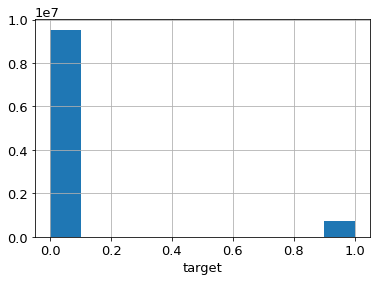

In [ ]:
plt.hist(train["target"])
plt.grid()
plt.xlabel("target")
plt.show()

# Check Maximum Score

In [ ]:
# https://www.kaggle.com/code/columbia2131/foursquare-iou-metrics
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

id2poi = get_id2poi(train)
poi2ids = get_poi2ids(train)

In [ ]:
def get_score(id2ids: dict):
    scores = []
    precisions = []
    recalls = []
    for id_str in train['id'].unique():
        if id_str in id2ids:
            preds = id2ids[id_str]
        else:
            preds = set()
        preds.add(id_str)
        targets = poi2ids[id2poi[id_str]]
        score = len((targets & preds)) / len((targets | preds))
        if len(preds) == 0:
            precision = 0
        else:
            precision = len((targets & preds)) / len(preds)
        recall = len((targets & preds)) / len(targets)
        scores.append(score)
        precisions.append(precision)
        recalls.append(recall)
    scores = np.array(scores)
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    return scores.mean(), precisions.mean(), recalls.mean()

In [ ]:
id2ids = train[train[CFG.target] == train['near_target']].groupby('id')['near_id'].apply(lambda x: set(x))
score, precision, recall = get_score(id2ids)
print(score)

0.8904038900654864


In [ ]:
# del train
# gc.collect()

# Feature Engineering

In [ ]:
if "google.colab" in sys.modules:
    !pip install Levenshtein

In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
import Levenshtein
import difflib

def _add_distance_features(args):
    _, df = args

    columns = ['name', 'address', 'city', 'state',
           'zip', 'country', 'url', 'phone', 'categories']

    for c in columns:
        geshs = []
        levens = []
        jaros = []
        lcss = []
        for str1, str2 in df[[c, f"near_{c}"]].values.astype(str):
            if str1==str1 and str2==str2:
                geshs.append(difflib.SequenceMatcher(None, str1, str2).ratio())
                levens.append(Levenshtein.distance(str1, str2))
                jaros.append(Levenshtein.jaro_winkler(str1, str2))
                lcss.append(LCS(str(str1), str(str2)))
            else:
                geshs.append(-1)
                levens.append(-1)
                jaros.append(-1)
        df[f"near_{c}_gesh"] = geshs
        df[f"near_{c}_leven"] = levens
        df[f"near_{c}_jaro"] = jaros
        df[f"near_{c}_lcs"] = lcss
        
        if not c in ['country', "phone", "zip"]:
            df[f"{c}_len"] = df[c].astype(str).map(len)
            df[f"near_{c}_len"] = df[f"near_{c}"].astype(str).map(len)
            df[f"near_{c}_nleven"] = df[f"near_{c}_leven"] / df[[f"near_{c}_len", f"{c}_len"]].max(axis=1)
            df[f"near_{c}_nlcsi"] = df[f"near_{c}_lcs"] / df[f"near_{c}_len"]
            df[f"near_{c}_nlcs0"] = df[f"near_{c}_lcs"] / df[f"{c}_len"]
    return df

def add_distance_features(df):
    processes = multiprocessing.cpu_count()
    with multiprocessing.Pool(processes=processes) as pool:
        dfs = pool.imap_unordered(_add_distance_features, df.groupby('country'))
        dfs = tqdm(dfs)
        dfs = list(dfs)
    df = pd.concat(dfs)
    return df

train_distance_features_path = os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "train_distance_features.csv"))
test_distance_features_path = os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "test_distance_features.csv"))

if CFG.save and (os.path.exists(train_distance_features_path) and os.path.exists(test_distance_features_path)):
    train = pd.read_csv(train_distance_features_path)
    test = pd.read_csv(test_distance_features_path)
else:
    train = add_distance_features(train)
    test = add_distance_features(test)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
display(train.head(1))
display(test.head(1))

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_phone_lcs,near_categories_gesh,near_categories_leven,near_categories_jaro,near_categories_lcs,categories_len,near_categories_len,near_categories_nleven,near_categories_nlcsi,near_categories_nlcs0
12,E_1104d3664585a4,mamá maría,42.508166,1.525205,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,nan,ad,nan,...,0,1.0,0,1.0,33,33,33,0.0,1.0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_phone_lcs,near_categories_gesh,near_categories_leven,near_categories_jaro,near_categories_lcs,categories_len,near_categories_len,near_categories_nleven,near_categories_nlcsi,near_categories_nlcs0
2,E_001b6bad66eb98,"gelora sriwijaya, jaka baring sport city",-3.014675,104.794374,nan,nan,nan,nan,id,nan,...,3,0.695652,7,0.461111,8,8,15,0.466667,0.533333,1.0


In [ ]:
if CFG.save and not (os.path.exists(train_distance_features_path) and os.path.exists(test_distance_features_path)):
    train.to_csv(train_distance_features_path, index=False)
    test.to_csv(test_distance_features_path, index=False)

# Delete Unusing Columns (just for avoiding OOM)

In [ ]:
train['country_pair'] = train[['country', 'near_country']].apply(lambda x: tuple(sorted(list(x))), axis = 1)
test['country_pair'] = test[['country', 'near_country']].apply(lambda x: tuple(sorted(list(x))), axis = 1)

In [ ]:
train.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_categories_gesh,near_categories_leven,near_categories_jaro,near_categories_lcs,categories_len,near_categories_len,near_categories_nleven,near_categories_nlcsi,near_categories_nlcs0,country_pair
12,E_1104d3664585a4,mamá maría,42.508166,1.525205,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,nan,ad,nan,...,1.000000,0,1.000000,33,33,33,0.000000,1.000000,1.000000,"(ad, ad)"
13,E_1514d74b987ae1,ahotels piolets park & spa,42.578021,1.663907,"carretera de soldeu, s/n",soldeu,andorra,ad100,ad,http://www.ahotels.com/,...,0.451613,17,0.406746,7,24,7,0.708333,1.000000,0.291667,"(ad, ad)"
14,E_206f06060f193d,la borda xica,42.571045,1.487248,cap del carrer,la massana,nan,nan,ad,nan,...,0.300000,8,0.670034,5,11,9,0.727273,0.555556,0.454545,"(ad, ad)"
15,E_20b7920b07557d,"escola de esquí el forn de canillo, grandvalira",42.556103,1.616165,"el forn de canillo, s/n",canillo,canillo,ad100,ad,nan,...,1.000000,0,1.000000,9,9,9,0.000000,1.000000,1.000000,"(ad, ad)"
16,E_4a34a5012e88c3,pic negre 11,42.546688,1.513963,nan,la massana,nan,ad400,ad,nan,...,1.000000,0,1.000000,20,20,20,0.000000,1.000000,1.000000,"(ad, ad)"


In [ ]:
features = []

columns = ['name', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories']

features.append(f"d_near")
for c in columns:        
    features += [f"near_{c}_gesh", f"near_{c}_jaro", f"near_{c}_lcs"]
    if c in ['country', "phone", "zip"]:
        features += [f"near_{c}_leven"]
    else:
        features += [f"near_{c}_len", f"near_{c}_nleven", f"near_{c}_nlcsi", f"near_{c}_nlcs0"]

for f in features:
#     assert f in train.columns
    if f not in test.columns:
        test[f] = np.nan

print(features)

['d_near', 'near_name_gesh', 'near_name_jaro', 'near_name_lcs', 'near_name_len', 'near_name_nleven', 'near_name_nlcsi', 'near_name_nlcs0', 'near_address_gesh', 'near_address_jaro', 'near_address_lcs', 'near_address_len', 'near_address_nleven', 'near_address_nlcsi', 'near_address_nlcs0', 'near_city_gesh', 'near_city_jaro', 'near_city_lcs', 'near_city_len', 'near_city_nleven', 'near_city_nlcsi', 'near_city_nlcs0', 'near_state_gesh', 'near_state_jaro', 'near_state_lcs', 'near_state_len', 'near_state_nleven', 'near_state_nlcsi', 'near_state_nlcs0', 'near_zip_gesh', 'near_zip_jaro', 'near_zip_lcs', 'near_zip_leven', 'near_country_gesh', 'near_country_jaro', 'near_country_lcs', 'near_country_leven', 'near_url_gesh', 'near_url_jaro', 'near_url_lcs', 'near_url_len', 'near_url_nleven', 'near_url_nlcsi', 'near_url_nlcs0', 'near_phone_gesh', 'near_phone_jaro', 'near_phone_lcs', 'near_phone_leven', 'near_categories_gesh', 'near_categories_jaro', 'near_categories_lcs', 'near_categories_len', 'near_

In [ ]:
train = train[features + [CFG.target, "target", "id", "near_id", "country_pair"]]
test = test[features + ["id", "near_id", "country_pair"]]

train[features] = train[features].astype(np.float16)
test[features] = test[features].astype(np.float16)

train["target"] = train["target"].fillna(0)

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

for _ in range(5):
    gc.collect()

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10248613 entries, 0 to 10248612
Data columns (total 60 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   d_near                  float16
 1   near_name_gesh          float16
 2   near_name_jaro          float16
 3   near_name_lcs           float16
 4   near_name_len           float16
 5   near_name_nleven        float16
 6   near_name_nlcsi         float16
 7   near_name_nlcs0         float16
 8   near_address_gesh       float16
 9   near_address_jaro       float16
 10  near_address_lcs        float16
 11  near_address_len        float16
 12  near_address_nleven     float16
 13  near_address_nlcsi      float16
 14  near_address_nlcs0      float16
 15  near_city_gesh          float16
 16  near_city_jaro          float16
 17  near_city_lcs           float16
 18  near_city_len           float16
 19  near_city_nleven        float16
 20  near_city_nlcsi         float16
 21  near_city_nlcs0         float

# Split Folds

In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
def get_distribution(y_vals):
        y_distr = Counter(y_vals)
        y_vals_sum = sum(y_distr.values())
        return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
distrs = [get_distribution(train["target"])]
index = ['training set']

for fold_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(train, train["target"], train["country_pair"], k=CFG.n_splits, seed=CFG.seed)):
    train.loc[val_ind, "fold"] = fold_ind

    dev_y, val_y = train.loc[dev_ind, "target"], train.loc[val_ind, "target"]
    dev_groups, val_groups = train.loc[dev_ind, "country_pair"], train.loc[val_ind, "country_pair"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(train["target"]) + 1)])

'Distribution per class:'

,Label 0,Label 1
training set,93.02%,6.98%
development set - fold 0,92.84%,7.16%
validation set - fold 0,93.40%,6.60%
development set - fold 1,93.38%,6.62%
validation set - fold 1,92.32%,7.68%
development set - fold 2,92.86%,7.14%
validation set - fold 2,93.36%,6.64%


# Model Learning

In [ ]:
import lightgbm as lgbm

def fit_lgbm(X, y, params=None, es_rounds=20, seed=42, N_SPLITS=5, 
             n_class=None, model_dir=None, folds=None):
    models = []
    oof = np.zeros((len(y), 2), dtype=np.float64)
    
    for i in tqdm(range(CFG.n_splits)):
        print(f"== fold {i} ==")
        trn_idx = folds!=i
        val_idx = folds==i
        X_train, y_train = X[trn_idx], y.iloc[trn_idx]
        X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

        if model_dir is None:
            model = lgbm.LGBMClassifier(**params)
            model.fit(
                X_train, y_train, 
                eval_set=[(X_valid, y_valid)],  
                early_stopping_rounds=es_rounds, 
                eval_metric='binary',  
    #             verbose=-1)
                verbose=50)
        else:
            with open(f'{model_dir}/lgbm_fold{i}.pkl', 'rb') as f:
                model = pickle.load(f)
            
        pred = model.predict_proba(X_valid)
        oof[val_idx] = pred
        models.append(model)
        
        file = os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, f'lgbm_fold{i}.pkl'))
        pickle.dump(model, open(file, 'wb'))
        print()

    cv = (oof.argmax(axis=-1) == y).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgbm(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}

if os.path.exists(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, 'lgbm_fold0.pkl'))):
    models = [joblib.load(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, f'lgbm_fold{i}.pkl'))) for i in range(CFG.n_splits)]
    oof = pd.read_csv(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "oof.csv")))
    oof = oof.values
else:
    oof, models = fit_lgbm(train[features], train["target"].astype(int), 
                          params=params, n_class=2, 
                          N_SPLITS=CFG.n_splits, folds=train["fold"].values)
    pd.DataFrame(oof).to_csv(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "oof.csv")), index = False)
pred = inference_lgbm(models, test[features])

  0%|          | 0/3 [00:00<?, ?it/s]

== fold 0 ==
[50]	valid_0's binary_logloss: 0.0725927

== fold 1 ==
[50]	valid_0's binary_logloss: 0.113478
[100]	valid_0's binary_logloss: 0.111357
[150]	valid_0's binary_logloss: 0.110607
[200]	valid_0's binary_logloss: 0.110224
[250]	valid_0's binary_logloss: 0.110008
[300]	valid_0's binary_logloss: 0.109799

== fold 2 ==
[50]	valid_0's binary_logloss: 0.0937571
[100]	valid_0's binary_logloss: 0.0924098
[150]	valid_0's binary_logloss: 0.0916328
[200]	valid_0's binary_logloss: 0.0913091

CV-accuracy: 0.9661666412811177


In [ ]:
train["pred"] = oof[:, -1]

# Check CV

In [ ]:
!pip install optuna

     |████████████████████████████████| 308 kB 27.1 MB/s 
     |████████████████████████████████| 81 kB 10.7 MB/s 
     |████████████████████████████████| 210 kB 57.1 MB/s 
     |████████████████████████████████| 78 kB 8.3 MB/s 
     |████████████████████████████████| 146 kB 70.1 MB/s 
     |████████████████████████████████| 49 kB 7.9 MB/s 
     |████████████████████████████████| 112 kB 75.0 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=ea6ebb71807c62df202600034d5a56a2e0eaea471581afff1e46809b874afd99
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    id2ids = train[train["pred"] > x].groupby('id')['near_id'].apply(lambda x: set(x))
    score, precision, recall = get_score(id2ids)
    print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-13 09:33:55,733] A new study created in memory with name: no-name-67cebb55-4b33-48ce-8802-b154fb74386b
[I 2022-05-13 09:34:21,812] Trial 0 finished with value: 0.7492214890240401 and parameters: {'threshold': 0.11008371420064766}. Best is trial 0 with value: 0.7492214890240401.


CV: 0.749221, precision: 0.853824, recall: 0.871703


[I 2022-05-13 09:34:41,168] Trial 1 finished with value: 0.7982138470776374 and parameters: {'threshold': 0.5757060195352237}. Best is trial 1 with value: 0.7982138470776374.


CV: 0.798214, precision: 0.968563, recall: 0.824813


[I 2022-05-13 09:35:02,983] Trial 2 finished with value: 0.7876568436712523 and parameters: {'threshold': 0.26079854865054874}. Best is trial 1 with value: 0.7982138470776374.


CV: 0.787657, precision: 0.918127, recall: 0.857164


[I 2022-05-13 09:35:26,483] Trial 3 finished with value: 0.7686035633885998 and parameters: {'threshold': 0.16023126249717534}. Best is trial 1 with value: 0.7982138470776374.


CV: 0.768604, precision: 0.883732, recall: 0.866541


[I 2022-05-13 09:35:41,299] Trial 4 finished with value: 0.7631011697946791 and parameters: {'threshold': 0.8680898991510487}. Best is trial 1 with value: 0.7982138470776374.


CV: 0.763101, precision: 0.993309, recall: 0.768702


[I 2022-05-13 09:35:51,291] Trial 5 finished with value: 0.7026768713314119 and parameters: {'threshold': 0.9653890667742964}. Best is trial 1 with value: 0.7982138470776374.


CV: 0.702677, precision: 0.999005, recall: 0.703499


[I 2022-05-13 09:35:59,223] Trial 6 finished with value: 0.6632175434440782 and parameters: {'threshold': 0.9891648791733728}. Best is trial 1 with value: 0.7982138470776374.


CV: 0.663218, precision: 0.999874, recall: 0.663323


[I 2022-05-13 09:36:13,386] Trial 7 finished with value: 0.7548652853710881 and parameters: {'threshold': 0.8910813628439753}. Best is trial 1 with value: 0.7982138470776374.


CV: 0.754865, precision: 0.994773, recall: 0.759221


[I 2022-05-13 09:36:37,405] Trial 8 finished with value: 0.7695688614004457 and parameters: {'threshold': 0.16358762727885445}. Best is trial 1 with value: 0.7982138470776374.


CV: 0.769569, precision: 0.885297, recall: 0.866220


[I 2022-05-13 09:36:51,030] Trial 9 finished with value: 0.7467183540535361 and parameters: {'threshold': 0.9093566186679574}. Best is trial 1 with value: 0.7982138470776374.


CV: 0.746718, precision: 0.995927, recall: 0.750084


[I 2022-05-13 09:37:09,547] Trial 10 finished with value: 0.7975473812278858 and parameters: {'threshold': 0.5945988609747116}. Best is trial 1 with value: 0.7982138470776374.


CV: 0.797547, precision: 0.970714, recall: 0.822384


[I 2022-05-13 09:37:28,169] Trial 11 finished with value: 0.7979933111674913 and parameters: {'threshold': 0.5827566776464783}. Best is trial 1 with value: 0.7982138470776374.


CV: 0.797993, precision: 0.969358, recall: 0.823928


[I 2022-05-13 09:37:46,836] Trial 12 finished with value: 0.7981401443131714 and parameters: {'threshold': 0.5778088630684726}. Best is trial 1 with value: 0.7982138470776374.


CV: 0.798140, precision: 0.968796, recall: 0.824547


[I 2022-05-13 09:38:07,318] Trial 13 finished with value: 0.7983732484049134 and parameters: {'threshold': 0.41935973859192166}. Best is trial 13 with value: 0.7983732484049134.


CV: 0.798373, precision: 0.948353, recall: 0.842232


[I 2022-05-13 09:38:28,386] Trial 14 finished with value: 0.7966457992183672 and parameters: {'threshold': 0.3722849043130834}. Best is trial 13 with value: 0.7983732484049134.


CV: 0.796646, precision: 0.940969, recall: 0.846865


[I 2022-05-13 09:38:45,719] Trial 15 finished with value: 0.7881540564416214 and parameters: {'threshold': 0.7320865306938649}. Best is trial 13 with value: 0.7983732484049134.


CV: 0.788154, precision: 0.983730, recall: 0.801957


[I 2022-05-13 09:39:05,375] Trial 16 finished with value: 0.799377377133276 and parameters: {'threshold': 0.481400020186893}. Best is trial 16 with value: 0.799377377133276.


CV: 0.799377, precision: 0.956993, recall: 0.835807


[I 2022-05-13 09:39:26,689] Trial 17 finished with value: 0.7978984497951132 and parameters: {'threshold': 0.40293402586626825}. Best is trial 16 with value: 0.799377377133276.


CV: 0.797898, precision: 0.945891, recall: 0.843886


[I 2022-05-13 09:39:59,615] Trial 18 finished with value: 0.5774840863684414 and parameters: {'threshold': 0.013651289373094122}. Best is trial 16 with value: 0.799377377133276.


CV: 0.577484, precision: 0.630910, recall: 0.885756


[I 2022-05-13 09:40:19,066] Trial 19 finished with value: 0.7983986573836754 and parameters: {'threshold': 0.42008042309984905}. Best is trial 16 with value: 0.799377377133276.


CV: 0.798399, precision: 0.948461, recall: 0.842165


[I 2022-05-13 09:40:35,938] Trial 20 finished with value: 0.7862272671954325 and parameters: {'threshold': 0.749395624809736}. Best is trial 16 with value: 0.799377377133276.


CV: 0.786227, precision: 0.985079, recall: 0.798863


[I 2022-05-13 09:40:57,161] Trial 21 finished with value: 0.797997611013497 and parameters: {'threshold': 0.40633369149976345}. Best is trial 16 with value: 0.799377377133276.


CV: 0.797998, precision: 0.946402, recall: 0.843543


[I 2022-05-13 09:41:18,670] Trial 22 finished with value: 0.7931801189510133 and parameters: {'threshold': 0.31637577289525304}. Best is trial 16 with value: 0.799377377133276.


CV: 0.793180, precision: 0.930813, recall: 0.852036


[I 2022-05-13 09:41:38,491] Trial 23 finished with value: 0.7991760038941823 and parameters: {'threshold': 0.4586999319133134}. Best is trial 16 with value: 0.799377377133276.


CV: 0.799176, precision: 0.953949, recall: 0.838229


[I 2022-05-13 09:41:58,559] Trial 24 finished with value: 0.7991385697750829 and parameters: {'threshold': 0.4541970856711357}. Best is trial 16 with value: 0.799377377133276.


CV: 0.799139, precision: 0.953342, recall: 0.838714


[I 2022-05-13 09:42:17,996] Trial 25 finished with value: 0.7993995566881896 and parameters: {'threshold': 0.49319414769586023}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.799400, precision: 0.958521, recall: 0.834511


[I 2022-05-13 09:42:38,375] Trial 26 finished with value: 0.7993642323008984 and parameters: {'threshold': 0.49851524223328836}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.799364, precision: 0.959166, recall: 0.833914


[I 2022-05-13 09:42:54,818] Trial 27 finished with value: 0.7922583209843517 and parameters: {'threshold': 0.688909403387038}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.792258, precision: 0.980190, recall: 0.809120


[I 2022-05-13 09:43:14,708] Trial 28 finished with value: 0.7991649821084946 and parameters: {'threshold': 0.5265827168446753}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.799165, precision: 0.962650, recall: 0.830707


[I 2022-05-13 09:43:32,403] Trial 29 finished with value: 0.7950005816165181 and parameters: {'threshold': 0.6498829548922658}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.795001, precision: 0.976624, recall: 0.814942


[I 2022-05-13 09:43:54,221] Trial 30 finished with value: 0.7899045317050284 and parameters: {'threshold': 0.28137648431809603}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.789905, precision: 0.923103, recall: 0.855241


[I 2022-05-13 09:44:13,867] Trial 31 finished with value: 0.7993555813964115 and parameters: {'threshold': 0.4767422108146883}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.799356, precision: 0.956387, recall: 0.836306


[I 2022-05-13 09:44:33,119] Trial 32 finished with value: 0.7992950322135539 and parameters: {'threshold': 0.5186510392262073}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.799295, precision: 0.961683, recall: 0.831666


[I 2022-05-13 09:44:54,212] Trial 33 finished with value: 0.795130593235491 and parameters: {'threshold': 0.3435223744936396}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.795131, precision: 0.936040, recall: 0.849559


[I 2022-05-13 09:45:13,678] Trial 34 finished with value: 0.7993621491674644 and parameters: {'threshold': 0.49802512908698837}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.799362, precision: 0.959106, recall: 0.833966


[I 2022-05-13 09:45:37,393] Trial 35 finished with value: 0.7821086403457121 and parameters: {'threshold': 0.22180927314736615}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.782109, precision: 0.907138, recall: 0.860760


[I 2022-05-13 09:45:55,739] Trial 36 finished with value: 0.7991743756616648 and parameters: {'threshold': 0.5262799276833484}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.799174, precision: 0.962617, recall: 0.830742


[I 2022-05-13 09:46:14,556] Trial 37 finished with value: 0.7957450661944395 and parameters: {'threshold': 0.6367305777189507}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.795745, precision: 0.975278, recall: 0.816826


[I 2022-05-13 09:46:30,497] Trial 38 finished with value: 0.7837474048757929 and parameters: {'threshold': 0.7688961883233938}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.783747, precision: 0.986540, recall: 0.795132


[I 2022-05-13 09:46:46,632] Trial 39 finished with value: 0.7787983076950667 and parameters: {'threshold': 0.8011519744672442}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.778798, precision: 0.988822, recall: 0.788218


[I 2022-05-13 09:47:05,788] Trial 40 finished with value: 0.7993255482926036 and parameters: {'threshold': 0.5138273604693537}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.799326, precision: 0.961093, recall: 0.832206


[I 2022-05-13 09:47:26,687] Trial 41 finished with value: 0.7991811441117754 and parameters: {'threshold': 0.4590550810671945}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.799181, precision: 0.954000, recall: 0.838190


[I 2022-05-13 09:47:46,416] Trial 42 finished with value: 0.7993709006740899 and parameters: {'threshold': 0.4807794238827035}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.799371, precision: 0.956908, recall: 0.835874


[I 2022-05-13 09:48:03,653] Trial 43 finished with value: 0.7958911446736178 and parameters: {'threshold': 0.6341080092928001}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.795891, precision: 0.975023, recall: 0.817191


[I 2022-05-13 09:48:23,249] Trial 44 finished with value: 0.7986255130190686 and parameters: {'threshold': 0.5618921271872638}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.798626, precision: 0.967003, recall: 0.826546


[I 2022-05-13 09:48:44,473] Trial 45 finished with value: 0.7952666816149334 and parameters: {'threshold': 0.3457036107931776}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.795267, precision: 0.936444, recall: 0.849346


[I 2022-05-13 09:49:03,393] Trial 46 finished with value: 0.7986435157384596 and parameters: {'threshold': 0.561128518519134}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.798644, precision: 0.966914, recall: 0.826641


[I 2022-05-13 09:49:25,733] Trial 47 finished with value: 0.7868799110398927 and parameters: {'threshold': 0.25479084945916985}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.786880, precision: 0.916539, recall: 0.857711


[I 2022-05-13 09:49:44,148] Trial 48 finished with value: 0.7972317241178308 and parameters: {'threshold': 0.6030832787516175}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.797232, precision: 0.971676, recall: 0.821301


[I 2022-05-13 09:50:03,827] Trial 49 finished with value: 0.7993699085526945 and parameters: {'threshold': 0.4808743278565638}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.799370, precision: 0.956919, recall: 0.835863


[I 2022-05-13 09:50:24,566] Trial 50 finished with value: 0.7969049016125632 and parameters: {'threshold': 0.37843087801656045}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.796905, precision: 0.941984, recall: 0.846253


[I 2022-05-13 09:50:44,182] Trial 51 finished with value: 0.799382964696517 and parameters: {'threshold': 0.4848231037352885}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.799383, precision: 0.957430, recall: 0.835438


[I 2022-05-13 09:51:04,370] Trial 52 finished with value: 0.7987682941734362 and parameters: {'threshold': 0.43546111278876176}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.798768, precision: 0.950711, recall: 0.840603


[I 2022-05-13 09:51:24,825] Trial 53 finished with value: 0.7993800455241378 and parameters: {'threshold': 0.48885011549725926}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.799380, precision: 0.957945, recall: 0.834986


[I 2022-05-13 09:51:43,731] Trial 54 finished with value: 0.7989787628781232 and parameters: {'threshold': 0.5458933677279991}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.798979, precision: 0.965121, recall: 0.828474


[I 2022-05-13 09:52:04,414] Trial 55 finished with value: 0.7970772139440365 and parameters: {'threshold': 0.3819447141916292}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.797077, precision: 0.942557, recall: 0.845933


[I 2022-05-13 09:52:21,763] Trial 56 finished with value: 0.7928718226059105 and parameters: {'threshold': 0.6808666178875385}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.792872, precision: 0.979467, recall: 0.810352


[I 2022-05-13 09:52:40,242] Trial 57 finished with value: 0.7977771249699096 and parameters: {'threshold': 0.5885902771932794}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.797777, precision: 0.970013, recall: 0.823167


[I 2022-05-13 09:52:59,909] Trial 58 finished with value: 0.7993828485376454 and parameters: {'threshold': 0.4840680099949868}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.799383, precision: 0.957330, recall: 0.835519


[I 2022-05-13 09:53:20,006] Trial 59 finished with value: 0.798857885218662 and parameters: {'threshold': 0.43922727096482406}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.798858, precision: 0.951267, recall: 0.840211


[I 2022-05-13 09:53:41,425] Trial 60 finished with value: 0.7938605578003002 and parameters: {'threshold': 0.3253957017339234}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.793861, precision: 0.932587, recall: 0.851210


[I 2022-05-13 09:54:00,971] Trial 61 finished with value: 0.7993672651334462 and parameters: {'threshold': 0.4805279101828235}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.799367, precision: 0.956877, recall: 0.835898


[I 2022-05-13 09:54:21,379] Trial 62 finished with value: 0.7978945897468026 and parameters: {'threshold': 0.4027601129968026}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.797895, precision: 0.945863, recall: 0.843905


[I 2022-05-13 09:54:41,078] Trial 63 finished with value: 0.7993483307835367 and parameters: {'threshold': 0.47574355494807036}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.799348, precision: 0.956252, recall: 0.836417


[I 2022-05-13 09:55:00,884] Trial 64 finished with value: 0.7989935377193388 and parameters: {'threshold': 0.5408583458609093}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.798994, precision: 0.964404, recall: 0.829062


[I 2022-05-13 09:55:19,507] Trial 65 finished with value: 0.7971999530410668 and parameters: {'threshold': 0.6036383265654417}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.797200, precision: 0.971726, recall: 0.821225


[I 2022-05-13 09:55:39,883] Trial 66 finished with value: 0.7983162181110609 and parameters: {'threshold': 0.4173322014901988}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.798316, precision: 0.948060, recall: 0.842430


[I 2022-05-13 09:55:59,751] Trial 67 finished with value: 0.7993937440773479 and parameters: {'threshold': 0.49393574654516975}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.799394, precision: 0.958599, recall: 0.834433


[I 2022-05-13 09:56:19,297] Trial 68 finished with value: 0.7993688086311673 and parameters: {'threshold': 0.4992272072549252}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.799369, precision: 0.959268, recall: 0.833830


[I 2022-05-13 09:56:39,304] Trial 69 finished with value: 0.799026458665873 and parameters: {'threshold': 0.44751665924080397}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.799026, precision: 0.952425, recall: 0.839389


[I 2022-05-13 09:57:00,310] Trial 70 finished with value: 0.7962220796993554 and parameters: {'threshold': 0.36339810015734314}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.796222, precision: 0.939511, recall: 0.847709


[I 2022-05-13 09:57:19,898] Trial 71 finished with value: 0.7993881223423517 and parameters: {'threshold': 0.4849962636908946}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.799388, precision: 0.957459, recall: 0.835419


[I 2022-05-13 09:57:38,687] Trial 72 finished with value: 0.7989263326011197 and parameters: {'threshold': 0.5485040393399769}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.798926, precision: 0.965442, recall: 0.828155


[I 2022-05-13 09:57:58,786] Trial 73 finished with value: 0.7993694315845453 and parameters: {'threshold': 0.502497176854701}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.799369, precision: 0.959685, recall: 0.833465


[I 2022-05-13 09:58:19,237] Trial 74 finished with value: 0.7978290468950306 and parameters: {'threshold': 0.40076414347879985}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.797829, precision: 0.945561, recall: 0.844101


[I 2022-05-13 09:58:37,740] Trial 75 finished with value: 0.7981907101678462 and parameters: {'threshold': 0.5765903761435573}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.798191, precision: 0.968663, recall: 0.824707


[I 2022-05-13 09:58:57,545] Trial 76 finished with value: 0.7992367488756289 and parameters: {'threshold': 0.46405035397720906}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.799237, precision: 0.954681, recall: 0.837659


[I 2022-05-13 09:59:16,788] Trial 77 finished with value: 0.799204170664095 and parameters: {'threshold': 0.5245396562983022}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.799204, precision: 0.962404, recall: 0.830958


[I 2022-05-13 09:59:35,183] Trial 78 finished with value: 0.7966137278351854 and parameters: {'threshold': 0.6177376189854135}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.796614, precision: 0.973189, recall: 0.819388


[I 2022-05-13 10:00:02,643] Trial 79 finished with value: 0.6972895527042545 and parameters: {'threshold': 0.048699068451812266}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.697290, precision: 0.781297, recall: 0.879180


[I 2022-05-13 10:00:23,660] Trial 80 finished with value: 0.7986001242866244 and parameters: {'threshold': 0.4286613989509608}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.798600, precision: 0.949726, recall: 0.841278


[I 2022-05-13 10:00:43,301] Trial 81 finished with value: 0.7993785546679104 and parameters: {'threshold': 0.48747733504012764}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.799379, precision: 0.957774, recall: 0.835134


[I 2022-05-13 10:01:02,973] Trial 82 finished with value: 0.7993648696384492 and parameters: {'threshold': 0.5027637904557342}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.799365, precision: 0.959715, recall: 0.833434


[I 2022-05-13 10:01:23,264] Trial 83 finished with value: 0.7991126402752176 and parameters: {'threshold': 0.4531453924167449}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.799113, precision: 0.953196, recall: 0.838813


[I 2022-05-13 10:01:42,529] Trial 84 finished with value: 0.7991184406075486 and parameters: {'threshold': 0.5325851264923502}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.799118, precision: 0.963410, recall: 0.830030


[I 2022-05-13 10:02:01,363] Trial 85 finished with value: 0.7985094572872677 and parameters: {'threshold': 0.5665391526037079}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.798509, precision: 0.967526, recall: 0.825986


[I 2022-05-13 10:02:20,920] Trial 86 finished with value: 0.7993952519388425 and parameters: {'threshold': 0.4915516767074198}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.799395, precision: 0.958308, recall: 0.834691


[I 2022-05-13 10:02:40,445] Trial 87 finished with value: 0.799388045479101 and parameters: {'threshold': 0.4906827312760514}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.799388, precision: 0.958196, recall: 0.834781


[I 2022-05-13 10:02:57,885] Trial 88 finished with value: 0.7942086929066025 and parameters: {'threshold': 0.6619801395208895}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.794209, precision: 0.977776, recall: 0.813164


[I 2022-05-13 10:03:17,974] Trial 89 finished with value: 0.797370125058083 and parameters: {'threshold': 0.38877767671249347}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.797370, precision: 0.943671, recall: 0.845275


[I 2022-05-13 10:03:38,605] Trial 90 finished with value: 0.7985408201280724 and parameters: {'threshold': 0.42615078768686837}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.798541, precision: 0.949351, recall: 0.841542


[I 2022-05-13 10:03:58,561] Trial 91 finished with value: 0.7993786321910135 and parameters: {'threshold': 0.48126853881317855}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.799379, precision: 0.956975, recall: 0.835824


[I 2022-05-13 10:04:17,553] Trial 92 finished with value: 0.799359304362236 and parameters: {'threshold': 0.5049016193562795}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.799359, precision: 0.959976, recall: 0.833205


[I 2022-05-13 10:04:36,946] Trial 93 finished with value: 0.7992093059975056 and parameters: {'threshold': 0.4625016241607555}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.799209, precision: 0.954458, recall: 0.837820


[I 2022-05-13 10:04:55,425] Trial 94 finished with value: 0.7989090514611473 and parameters: {'threshold': 0.5489027422491712}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.798909, precision: 0.965482, recall: 0.828103


[I 2022-05-13 10:05:14,720] Trial 95 finished with value: 0.7993865150881405 and parameters: {'threshold': 0.4857342776150537}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.799387, precision: 0.957558, recall: 0.835328


[I 2022-05-13 10:05:33,513] Trial 96 finished with value: 0.7992602766237118 and parameters: {'threshold': 0.5210396596175549}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.799260, precision: 0.961975, recall: 0.831384


[I 2022-05-13 10:05:54,102] Trial 97 finished with value: 0.7990142257544682 and parameters: {'threshold': 0.4469200913187048}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.799014, precision: 0.952343, recall: 0.839448


[I 2022-05-13 10:06:11,384] Trial 98 finished with value: 0.7979589277656206 and parameters: {'threshold': 0.5839625717298516}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.797959, precision: 0.969496, recall: 0.823785


[I 2022-05-13 10:06:32,760] Trial 99 finished with value: 0.7957927683706421 and parameters: {'threshold': 0.3556128372258943}. Best is trial 25 with value: 0.7993995566881896.


CV: 0.795793, precision: 0.938145, recall: 0.848434


In [ ]:
threshold = study.best_params['threshold']
threshold

0.49319414769586023

In [ ]:
study.best_value

0.7993995566881896

In [ ]:
id2ids = train[train["pred"] > threshold].groupby('id')['near_id'].apply(lambda x: set(x))
score, precision, recall = get_score(id2ids)
print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")

CV: 0.799400, precision: 0.958521, recall: 0.834511


# Check Feature Importances

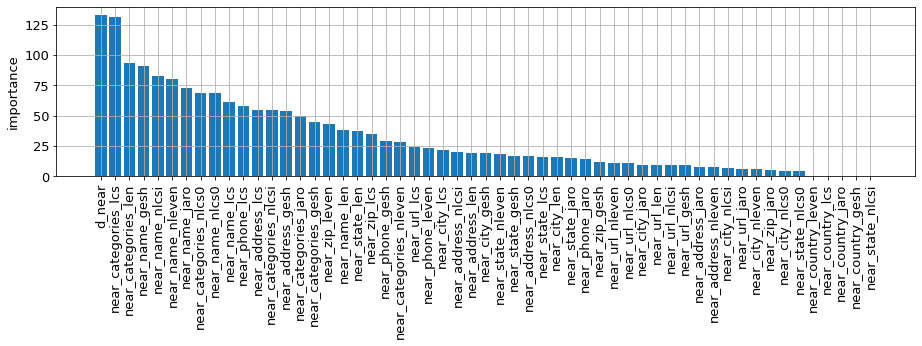

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

# Simple Post-Processing

In [ ]:
import optuna
from copy import deepcopy

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    id2ids = train[train["pred"] > x].groupby('id')['near_id'].apply(lambda x: set(x))
    train["matches"] = train["id"]a
    if len(id2ids) > 0:
        train.loc[train["id"].isin(id2ids.keys()), "matches"] += " " + train.loc[train["id"].isin(id2ids.keys()), "id"].map(id2ids).map(lambda x: " ".join(x))
    id2match = dict(zip(train["id"].values, train["matches"].str.split()))

    for match in tqdm(train["matches"]):
        match = match.split()
        if len(match) == 1:
            continue

        base = match[0]
        for m in match[1:]:
            if not base in id2match[m]:
                id2match[m].append(base)
    id2ids = deepcopy(id2match)
    for id, ids in id2ids.items():
        id2ids[id] = set(ids)
    score, precision, recall = get_score(id2ids)
    print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-13 10:06:52,952] A new study created in memory with name: no-name-a1cadece-d23c-468e-9fff-deacfd57793b


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 10:07:52,902] Trial 0 finished with value: 0.7990676998370289 and parameters: {'threshold': 0.6864927565347085}. Best is trial 0 with value: 0.7990676998370289.


CV: 0.799068, precision: 0.975955, recall: 0.819620


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.792722, precision: 0.919169, recall: 0.861955


[I 2022-05-13 10:09:06,091] Trial 1 finished with value: 0.7927215011614797 and parameters: {'threshold': 0.31004800570660607}. Best is trial 0 with value: 0.7990676998370289.


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.802112, precision: 0.945889, recall: 0.848339


[I 2022-05-13 10:10:10,518] Trial 2 finished with value: 0.8021120817166622 and parameters: {'threshold': 0.4542394310401481}. Best is trial 2 with value: 0.8021120817166622.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 10:11:05,701] Trial 3 finished with value: 0.7770368062810993 and parameters: {'threshold': 0.84998319814701}. Best is trial 2 with value: 0.8021120817166622.


CV: 0.777037, precision: 0.990256, recall: 0.785240


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 10:12:17,186] Trial 4 finished with value: 0.7899396708389439 and parameters: {'threshold': 0.2866798083968668}. Best is trial 2 with value: 0.8021120817166622.


CV: 0.789940, precision: 0.913384, recall: 0.864058


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 10:13:15,909] Trial 5 finished with value: 0.7989709195356376 and parameters: {'threshold': 0.6878379565913595}. Best is trial 2 with value: 0.8021120817166622.


CV: 0.798971, precision: 0.976083, recall: 0.819410


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 10:14:14,650] Trial 6 finished with value: 0.78760779583183 and parameters: {'threshold': 0.7960031531506199}. Best is trial 2 with value: 0.8021120817166622.


CV: 0.787608, precision: 0.985929, recall: 0.799512


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.785814, precision: 0.905150, recall: 0.866864


[I 2022-05-13 10:15:27,180] Trial 7 finished with value: 0.7858139018809552 and parameters: {'threshold': 0.2564144167145559}. Best is trial 2 with value: 0.8021120817166622.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 10:16:16,377] Trial 8 finished with value: 0.7439307416936131 and parameters: {'threshold': 0.929513132131378}. Best is trial 2 with value: 0.8021120817166622.


CV: 0.743931, precision: 0.996362, recall: 0.746910


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.803188, precision: 0.953462, recall: 0.842836


[I 2022-05-13 10:17:21,857] Trial 9 finished with value: 0.8031876798733909 and parameters: {'threshold': 0.5062439246957162}. Best is trial 9 with value: 0.8031876798733909.


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.409599, precision: 0.434744, recall: 0.897437


[I 2022-05-13 10:19:44,010] Trial 10 finished with value: 0.409599009447154 and parameters: {'threshold': 0.005101777087136938}. Best is trial 9 with value: 0.8031876798733909.


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.802342, precision: 0.947156, recall: 0.847475


[I 2022-05-13 10:20:50,170] Trial 11 finished with value: 0.8023421413820835 and parameters: {'threshold': 0.4626554772813253}. Best is trial 9 with value: 0.8031876798733909.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 10:21:55,751] Trial 12 finished with value: 0.8031689702046665 and parameters: {'threshold': 0.5049681878991736}. Best is trial 9 with value: 0.8031876798733909.


CV: 0.803169, precision: 0.953279, recall: 0.842975


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 10:22:58,288] Trial 13 finished with value: 0.8031140480328363 and parameters: {'threshold': 0.5801124899616315}. Best is trial 9 with value: 0.8031876798733909.


CV: 0.803114, precision: 0.963455, recall: 0.834248


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 10:24:00,388] Trial 14 finished with value: 0.8031596974751508 and parameters: {'threshold': 0.5772766551656123}. Best is trial 9 with value: 0.8031876798733909.


CV: 0.803160, precision: 0.963098, recall: 0.834583


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 10:25:25,880] Trial 15 finished with value: 0.7351506442690171 and parameters: {'threshold': 0.09995213078968646}. Best is trial 9 with value: 0.8031876798733909.


CV: 0.735151, precision: 0.826584, recall: 0.881869


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.798213, precision: 0.932376, recall: 0.856155


[I 2022-05-13 10:26:34,855] Trial 16 finished with value: 0.7982130211170828 and parameters: {'threshold': 0.3738334984227991}. Best is trial 9 with value: 0.8031876798733909.


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.802871, precision: 0.964792, recall: 0.832903


[I 2022-05-13 10:27:35,130] Trial 17 finished with value: 0.8028710492265784 and parameters: {'threshold': 0.5905448401825835}. Best is trial 9 with value: 0.8031876798733909.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 10:28:54,175] Trial 18 finished with value: 0.7719209752112431 and parameters: {'threshold': 0.18782408767432712}. Best is trial 9 with value: 0.8031876798733909.


CV: 0.771921, precision: 0.881127, recall: 0.873077


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 10:30:03,104] Trial 19 finished with value: 0.7992476745834721 and parameters: {'threshold': 0.389704769872456}. Best is trial 9 with value: 0.8031876798733909.


CV: 0.799248, precision: 0.935298, recall: 0.854666


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 10:31:04,706] Trial 20 finished with value: 0.7994053068267629 and parameters: {'threshold': 0.6807314132990834}. Best is trial 9 with value: 0.8031876798733909.


CV: 0.799405, precision: 0.975333, recall: 0.820492


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.803422, precision: 0.958599, recall: 0.838670


[I 2022-05-13 10:32:13,127] Trial 21 finished with value: 0.8034222945298778 and parameters: {'threshold': 0.5433167492921631}. Best is trial 21 with value: 0.8034222945298778.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 10:33:23,517] Trial 22 finished with value: 0.8033680216024749 and parameters: {'threshold': 0.5333294187741775}. Best is trial 21 with value: 0.8034222945298778.


CV: 0.803368, precision: 0.957210, recall: 0.839792


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 10:34:30,924] Trial 23 finished with value: 0.8033757513615837 and parameters: {'threshold': 0.5387432805733077}. Best is trial 21 with value: 0.8034222945298778.


CV: 0.803376, precision: 0.957938, recall: 0.839182


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 10:35:37,091] Trial 24 finished with value: 0.7919702009935341 and parameters: {'threshold': 0.7635859234483449}. Best is trial 21 with value: 0.8034222945298778.


CV: 0.791970, precision: 0.983171, recall: 0.806261


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.802032, precision: 0.968628, recall: 0.828854


[I 2022-05-13 10:36:42,045] Trial 25 finished with value: 0.8020315600222163 and parameters: {'threshold': 0.6219260307076084}. Best is trial 21 with value: 0.8034222945298778.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 10:37:52,015] Trial 26 finished with value: 0.798256490132394 and parameters: {'threshold': 0.37471777202326195}. Best is trial 21 with value: 0.8034222945298778.


CV: 0.798256, precision: 0.932536, recall: 0.856055


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 10:38:56,874] Trial 27 finished with value: 0.8033286373844346 and parameters: {'threshold': 0.5246317349378709}. Best is trial 21 with value: 0.8034222945298778.


CV: 0.803329, precision: 0.955995, recall: 0.840781


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 10:39:35,386] Trial 28 finished with value: 0.6553764878916459 and parameters: {'threshold': 0.99410256679546}. Best is trial 21 with value: 0.8034222945298778.


CV: 0.655376, precision: 0.999949, recall: 0.655422


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 10:40:34,568] Trial 29 finished with value: 0.7974505526530062 and parameters: {'threshold': 0.708441787031279}. Best is trial 21 with value: 0.8034222945298778.


CV: 0.797451, precision: 0.978077, recall: 0.816153


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 10:41:43,181] Trial 30 finished with value: 0.8008721773601317 and parameters: {'threshold': 0.42305193180378076}. Best is trial 21 with value: 0.8034222945298778.


CV: 0.800872, precision: 0.940943, recall: 0.851388


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 10:42:45,995] Trial 31 finished with value: 0.803378001940204 and parameters: {'threshold': 0.5401197140797903}. Best is trial 21 with value: 0.8034222945298778.


CV: 0.803378, precision: 0.958122, recall: 0.839021


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.802152, precision: 0.967936, recall: 0.829549


[I 2022-05-13 10:43:47,237] Trial 32 finished with value: 0.8021522615502874 and parameters: {'threshold': 0.6165676320091981}. Best is trial 21 with value: 0.8034222945298778.


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.803237, precision: 0.954211, recall: 0.842235


[I 2022-05-13 10:44:51,366] Trial 33 finished with value: 0.8032373337298327 and parameters: {'threshold': 0.5116918273201145}. Best is trial 21 with value: 0.8034222945298778.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 10:45:52,750] Trial 34 finished with value: 0.8013407001615459 and parameters: {'threshold': 0.6414573645012567}. Best is trial 21 with value: 0.8034222945298778.


CV: 0.801341, precision: 0.970978, recall: 0.826211


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 10:47:04,407] Trial 35 finished with value: 0.7950157979424297 and parameters: {'threshold': 0.33282385227358324}. Best is trial 21 with value: 0.8034222945298778.


CV: 0.795016, precision: 0.924254, recall: 0.859911


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.801965, precision: 0.945283, recall: 0.848720


[I 2022-05-13 10:48:09,296] Trial 36 finished with value: 0.8019645329675652 and parameters: {'threshold': 0.4503088963686206}. Best is trial 21 with value: 0.8034222945298778.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 10:49:13,899] Trial 37 finished with value: 0.8034546702423824 and parameters: {'threshold': 0.5501150719333111}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.803455, precision: 0.959618, recall: 0.837862


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 10:50:10,893] Trial 38 finished with value: 0.7986105854685684 and parameters: {'threshold': 0.6933394445996449}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.798611, precision: 0.976615, recall: 0.818586


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 10:51:11,056] Trial 39 finished with value: 0.7930172743215801 and parameters: {'threshold': 0.7543558559012018}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.793017, precision: 0.982382, recall: 0.807998


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 10:52:14,068] Trial 40 finished with value: 0.803405647737789 and parameters: {'threshold': 0.5600517078622969}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.803406, precision: 0.960913, recall: 0.836708


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 10:53:17,386] Trial 41 finished with value: 0.8034072807470434 and parameters: {'threshold': 0.5554846250993624}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.803407, precision: 0.960311, recall: 0.837226


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 10:54:23,383] Trial 42 finished with value: 0.8022884964255999 and parameters: {'threshold': 0.46034668889761127}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.802288, precision: 0.946820, recall: 0.847710


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 10:55:16,968] Trial 43 finished with value: 0.777813134226051 and parameters: {'threshold': 0.8471503942213076}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.777813, precision: 0.990049, recall: 0.786194


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 10:56:18,502] Trial 44 finished with value: 0.8010386266065801 and parameters: {'threshold': 0.6484630512677318}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.801039, precision: 0.971813, recall: 0.825195


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 10:57:21,094] Trial 45 finished with value: 0.8032702280955357 and parameters: {'threshold': 0.5714482281248667}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.803270, precision: 0.962361, recall: 0.835322


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.800541, precision: 0.939635, recall: 0.852173


[I 2022-05-13 10:58:31,059] Trial 46 finished with value: 0.8005412605885112 and parameters: {'threshold': 0.41502966841910693}. Best is trial 37 with value: 0.8034546702423824.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 10:59:41,452] Trial 47 finished with value: 0.8027500973520691 and parameters: {'threshold': 0.4781788962975978}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.802750, precision: 0.949490, recall: 0.845866


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 11:00:47,627] Trial 48 finished with value: 0.803332792880793 and parameters: {'threshold': 0.5680642989291875}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.803333, precision: 0.961933, recall: 0.835759


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.788165, precision: 0.909726, recall: 0.865371


[I 2022-05-13 11:02:03,214] Trial 49 finished with value: 0.7881646347301476 and parameters: {'threshold': 0.27274834695662264}. Best is trial 37 with value: 0.8034546702423824.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 11:03:15,528] Trial 50 finished with value: 0.796306457027811 and parameters: {'threshold': 0.3474221963979387}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.796306, precision: 0.927344, recall: 0.858573


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.803407, precision: 0.960257, recall: 0.837274


[I 2022-05-13 11:04:19,508] Trial 51 finished with value: 0.8034070293404961 and parameters: {'threshold': 0.5550489259226231}. Best is trial 37 with value: 0.8034546702423824.


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.800578, precision: 0.972952, recall: 0.823745


[I 2022-05-13 11:05:19,021] Trial 52 finished with value: 0.8005784494147891 and parameters: {'threshold': 0.6585413568206517}. Best is trial 37 with value: 0.8034546702423824.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 11:06:20,756] Trial 53 finished with value: 0.8034397518313909 and parameters: {'threshold': 0.5489074082410555}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.803440, precision: 0.959433, recall: 0.837999


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 11:07:20,741] Trial 54 finished with value: 0.8024512031246457 and parameters: {'threshold': 0.6068919001692015}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.802451, precision: 0.966793, recall: 0.830831


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 11:08:25,675] Trial 55 finished with value: 0.8028830788748693 and parameters: {'threshold': 0.4835934259799858}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.802883, precision: 0.950268, recall: 0.845316


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 11:09:28,654] Trial 56 finished with value: 0.8034111370756326 and parameters: {'threshold': 0.5568642654448788}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.803411, precision: 0.960493, recall: 0.837074


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 11:10:30,665] Trial 57 finished with value: 0.7959385977232408 and parameters: {'threshold': 0.725223525640054}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.795939, precision: 0.979628, recall: 0.813305


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.803040, precision: 0.951855, recall: 0.844092


[I 2022-05-13 11:11:35,294] Trial 58 finished with value: 0.8030400285189342 and parameters: {'threshold': 0.4948908471521017}. Best is trial 37 with value: 0.8034546702423824.


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.801202, precision: 0.942287, recall: 0.850548


[I 2022-05-13 11:12:42,198] Trial 59 finished with value: 0.8012016664774138 and parameters: {'threshold': 0.4314149353814002}. Best is trial 37 with value: 0.8034546702423824.


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.779808, precision: 0.894370, recall: 0.869931


[I 2022-05-13 11:13:56,277] Trial 60 finished with value: 0.7798075618046417 and parameters: {'threshold': 0.22214684103777926}. Best is trial 37 with value: 0.8034546702423824.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 11:14:57,824] Trial 61 finished with value: 0.8034221714611997 and parameters: {'threshold': 0.5563351108893809}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.803422, precision: 0.960427, recall: 0.837141


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 11:16:00,408] Trial 62 finished with value: 0.8027733555586385 and parameters: {'threshold': 0.5935639843376849}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.802773, precision: 0.965139, recall: 0.832514


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 11:17:03,737] Trial 63 finished with value: 0.8034526340106385 and parameters: {'threshold': 0.5462295630936314}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.803453, precision: 0.959056, recall: 0.838326


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.803323, precision: 0.955492, recall: 0.841214


[I 2022-05-13 11:18:08,525] Trial 64 finished with value: 0.8033225332807924 and parameters: {'threshold': 0.5209790560472847}. Best is trial 37 with value: 0.8034546702423824.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 11:19:08,185] Trial 65 finished with value: 0.8002694070554871 and parameters: {'threshold': 0.664094175830889}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.800269, precision: 0.973536, recall: 0.822932


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 11:20:08,168] Trial 66 finished with value: 0.801547166706494 and parameters: {'threshold': 0.6360751255194417}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.801547, precision: 0.970346, recall: 0.826964


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 11:21:09,273] Trial 67 finished with value: 0.8026443211307993 and parameters: {'threshold': 0.6008259889185837}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.802644, precision: 0.966060, recall: 0.831641


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 11:22:14,717] Trial 68 finished with value: 0.8030009006173516 and parameters: {'threshold': 0.4916177588824162}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.803001, precision: 0.951408, recall: 0.844443


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 11:23:18,132] Trial 69 finished with value: 0.8033830373161032 and parameters: {'threshold': 0.5370665543593494}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.803383, precision: 0.957724, recall: 0.839374


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 11:24:27,979] Trial 70 finished with value: 0.7995023178048427 and parameters: {'threshold': 0.39397325386220605}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.799502, precision: 0.936038, recall: 0.854276


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.803380, precision: 0.961080, recall: 0.836535


[I 2022-05-13 11:25:29,301] Trial 71 finished with value: 0.8033800556176857 and parameters: {'threshold': 0.5614557959476663}. Best is trial 37 with value: 0.8034546702423824.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 11:26:32,142] Trial 72 finished with value: 0.8034278826086354 and parameters: {'threshold': 0.5526170234611858}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.803428, precision: 0.959918, recall: 0.837571


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 11:27:38,252] Trial 73 finished with value: 0.8020620804028123 and parameters: {'threshold': 0.4533284640234826}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.802062, precision: 0.945746, recall: 0.848415


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 11:28:38,307] Trial 74 finished with value: 0.802786444685046 and parameters: {'threshold': 0.5930317968352361}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.802786, precision: 0.965074, recall: 0.832582


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 11:29:42,422] Trial 75 finished with value: 0.8032358975975814 and parameters: {'threshold': 0.5116334162707443}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.803236, precision: 0.954204, recall: 0.842239


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 11:30:43,737] Trial 76 finished with value: 0.8017645083017144 and parameters: {'threshold': 0.6309165006921194}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.801765, precision: 0.969760, recall: 0.827682


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 11:31:47,854] Trial 77 finished with value: 0.803381596671681 and parameters: {'threshold': 0.5412442799639379}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.803382, precision: 0.958262, recall: 0.838906


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.799468, precision: 0.975221, recall: 0.820652


[I 2022-05-13 11:32:46,265] Trial 78 finished with value: 0.799467950610108 and parameters: {'threshold': 0.6796700511736276}. Best is trial 37 with value: 0.8034546702423824.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 11:33:46,678] Trial 79 finished with value: 0.8022404904567317 and parameters: {'threshold': 0.6144290411996253}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.802240, precision: 0.967684, recall: 0.829856


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 11:34:52,646] Trial 80 finished with value: 0.8027056636712285 and parameters: {'threshold': 0.47656799230534574}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.802706, precision: 0.949234, recall: 0.846039


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 11:35:56,525] Trial 81 finished with value: 0.80337337613816 and parameters: {'threshold': 0.5619611385081845}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.803373, precision: 0.961147, recall: 0.836469


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 11:36:59,922] Trial 82 finished with value: 0.8034418877274534 and parameters: {'threshold': 0.5483035684828904}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.803442, precision: 0.959352, recall: 0.838069


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 11:38:04,906] Trial 83 finished with value: 0.8032977245019355 and parameters: {'threshold': 0.5180158251167541}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.803298, precision: 0.955080, recall: 0.841544


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 11:39:05,898] Trial 84 finished with value: 0.803070888323015 and parameters: {'threshold': 0.5832609627801436}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.803071, precision: 0.963858, recall: 0.833862


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 11:40:14,746] Trial 85 finished with value: 0.8013509810087068 and parameters: {'threshold': 0.43490937532312063}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.801351, precision: 0.942858, recall: 0.850209


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 11:41:19,072] Trial 86 finished with value: 0.8031050739235341 and parameters: {'threshold': 0.500963310208209}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.803105, precision: 0.952733, recall: 0.843389


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 11:42:20,311] Trial 87 finished with value: 0.8034294124621225 and parameters: {'threshold': 0.5434003679972746}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.803429, precision: 0.958615, recall: 0.838662


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 11:43:24,887] Trial 88 finished with value: 0.8033664936143586 and parameters: {'threshold': 0.5334647190489875}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.803366, precision: 0.957228, recall: 0.839775


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.717630, precision: 0.802606, recall: 0.884406


[I 2022-05-13 11:44:51,415] Trial 89 finished with value: 0.7176296578657261 and parameters: {'threshold': 0.07726087695841083}. Best is trial 37 with value: 0.8034546702423824.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 11:45:59,875] Trial 90 finished with value: 0.8024851896895867 and parameters: {'threshold': 0.46610009884483156}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.802485, precision: 0.947712, recall: 0.847136


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 11:47:01,307] Trial 91 finished with value: 0.8031105767994858 and parameters: {'threshold': 0.5799334335077088}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.803111, precision: 0.963434, recall: 0.834262


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 11:48:03,793] Trial 92 finished with value: 0.8034231497597589 and parameters: {'threshold': 0.553416125582438}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.803423, precision: 0.960045, recall: 0.837475


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 11:49:05,008] Trial 93 finished with value: 0.80234658985052 and parameters: {'threshold': 0.6102076781630043}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.802347, precision: 0.967172, recall: 0.830404


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 11:50:07,781] Trial 94 finished with value: 0.8034510692003135 and parameters: {'threshold': 0.5458855892887643}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.803451, precision: 0.959009, recall: 0.838366


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 11:51:11,937] Trial 95 finished with value: 0.8033297549020295 and parameters: {'threshold': 0.5245888172225158}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.803330, precision: 0.955989, recall: 0.840787


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.800144, precision: 0.938220, recall: 0.853017


[I 2022-05-13 11:52:21,781] Trial 96 finished with value: 0.8001444234206816 and parameters: {'threshold': 0.4065990703968539}. Best is trial 37 with value: 0.8034546702423824.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 11:53:26,331] Trial 97 finished with value: 0.8030961251237856 and parameters: {'threshold': 0.49902569702657185}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.803096, precision: 0.952460, recall: 0.843621


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.801715, precision: 0.969957, recall: 0.827460


[I 2022-05-13 11:54:25,467] Trial 98 finished with value: 0.8017151100440707 and parameters: {'threshold': 0.6325632601506669}. Best is trial 37 with value: 0.8034546702423824.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-13 11:55:28,688] Trial 99 finished with value: 0.8033784083073594 and parameters: {'threshold': 0.5410925432964221}. Best is trial 37 with value: 0.8034546702423824.


CV: 0.803378, precision: 0.958241, recall: 0.838921


In [ ]:
threshold = study.best_params['threshold']
threshold

0.5501150719333111

In [ ]:
study.best_value

0.8034546702423824

In [ ]:
id2ids = train[train["pred"] > threshold].groupby('id')['near_id'].apply(lambda x: set(x))
train["matches"] = train["id"]
if len(id2ids) > 0:
    train.loc[train["id"].isin(id2ids.keys()), "matches"] += " " + train.loc[train["id"].isin(id2ids.keys()), "id"].map(id2ids).map(lambda x: " ".join(x))
id2match = dict(zip(train["id"].values, train["matches"].str.split()))

for match in tqdm(train["matches"]):
    match = match.split()
    if len(match) == 1:
        continue

    base = match[0]
    for m in match[1:]:
        if not base in id2match[m]:
            id2match[m].append(base)
id2ids = deepcopy(id2match)
for id, ids in id2ids.items():
    id2ids[id] = set(ids)
score, precision, recall = get_score(id2ids)
print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")

  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.803455, precision: 0.959618, recall: 0.837862


# Submit

In [ ]:
test["pred"] = pred[:, 1]

In [ ]:
ssub = pd.read_csv("../Input/sample_submission.csv")
ssub = ssub.drop(columns="matches")
id2ids = test[test["pred"] > threshold].groupby('id')['near_id'].apply(lambda x: set(x))
ssub["matches"] = ssub["id"]
if len(id2ids) > 0:
    ssub.loc[ssub["id"].isin(id2ids.keys()), "matches"] += " " + ssub.loc[ssub["id"].isin(id2ids.keys()), "id"].map(id2ids).map(lambda x: " ".join(x))
id2match = dict(zip(ssub["id"].values, ssub["matches"].str.split()))

for match in tqdm(ssub["matches"]):
    match = match.split()
    if len(match) == 1:
        continue

    base = match[0]
    for m in match[1:]:
        if not base in id2match[m]:
            id2match[m].append(base)

ssub["matches"] = ssub["id"].map(id2match).map(lambda x: " ".join(x))
ssub.to_csv(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "submission.csv")), index=False)

ssub.head()

  0%|          | 0/5 [00:00<?, ?it/s]

,id,matches
0,E_00001118ad0191,E_00001118ad0191
1,E_000020eb6fed40,E_000020eb6fed40
2,E_00002f98667edf,E_00002f98667edf
3,E_001b6bad66eb98,E_001b6bad66eb98 E_0283d9f61e569d
4,E_0283d9f61e569d,E_0283d9f61e569d E_001b6bad66eb98
